In [110]:
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import quandl
from scipy.stats import zscore
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from datetime import timedelta as td
import statsmodels.api as sm
import random
from functools import reduce

### **Data**

In [111]:
h_df = pd.read_csv(r'/Users/pr/Downloads/UChicago MSFM/Winter Quarter/QTS/Project/buy-rough-sell-smooth/Realized_H_Data.csv')
#h_df.rename(columns={'Ticker': 'ticker', 'Date': 'date', 'Price': 'price'}, inplace=True)
h_df.rename(columns={'Realized_H':'H_value'}, inplace=True)
h_df

,date,H_value,ticker,price
0,2010-01-29,0.137720,AAPL,192.063
1,2010-02-26,0.130794,AAPL,204.620
2,2010-03-31,0.071049,AAPL,235.000
3,2010-04-30,0.137683,AAPL,261.090
4,2010-05-28,5.734701,AAPL,256.880
...,...,...,...,...
15457,2023-04-28,0.023559,XOM,118.340
15458,2023-05-31,0.016606,XOM,102.180
15459,2023-06-30,0.052514,XOM,107.250
15460,2023-07-31,0.068541,XOM,107.240


In [112]:
# Count the rows where H_value > 1 or H_value < -1
extreme_count = h_df[(h_df["H_value"] > 1) | (h_df["H_value"] < -1)].shape[0]
print(f"Number of extreme H_values: {extreme_count}")

# Alternatively, count each separately:
count_above = h_df[h_df["H_value"] > 1].shape[0]
count_below = h_df[h_df["H_value"] < -1].shape[0]
print("Number of H_value > 1:", count_above)
print("Number of H_value < -1:", count_below)

Number of extreme H_values: 50
Number of H_value > 1: 50
Number of H_value < -1: 0


### **Rank H Values**

In [113]:
# Modify the function to rank h_vals into quintiles per date
def rank_H_quintiles(df):
    # Ensure date column is in datetime format
    monthly = df.copy()
    monthly["date"] = pd.to_datetime(monthly["date"])
    
    # Sort values by date and h_val
    monthly = monthly.sort_values(["date", "H_value"])
    
    # Assign quintile ranks (1 to 5) based on h_val per date
    monthly["h_rank"] = (
    monthly.groupby("date")["H_value"]
    .transform(lambda x: pd.qcut(-x, q=5, labels=False, duplicates='drop') + 1)
    )
    
    # Sort final result by ticker & date
    monthly = monthly.sort_values(["ticker", "date"]).reset_index(drop=True)
    
    return monthly


In [114]:
h_rank_df = rank_H_quintiles(h_df[h_df["H_value"] > 0])
h_rank_df

,date,H_value,ticker,price,h_rank
0,2010-01-29,0.137720,AAPL,192.063,1
1,2010-02-26,0.130794,AAPL,204.620,1
2,2010-03-31,0.071049,AAPL,235.000,3
3,2010-04-30,0.137683,AAPL,261.090,1
4,2010-05-28,5.734701,AAPL,256.880,1
...,...,...,...,...,...
15457,2023-04-28,0.023559,XOM,118.340,5
15458,2023-05-31,0.016606,XOM,102.180,5
15459,2023-06-30,0.052514,XOM,107.250,2
15460,2023-07-31,0.068541,XOM,107.240,4


### **Trading Strategy**

In [115]:
def generate_signal(rank_val, long=5, short=1, strat="long/short"):
    """
    Example signal generator for demonstration.
    Adjust as needed for your actual logic.
    """
    if strat == "long_only":
        return 1 if rank_val == long else 0
    elif strat == "short_only":
        return -1 if rank_val == short else 0
    else:  # long/short
        if rank_val == long:
            return 1
        elif rank_val == short:
            return -1
        else:
            return 0

In [116]:
import numpy as np
import pandas as pd

def trading_strategy(
    h_df,
    long=5,
    short=1,
    annual_short_borrow=0.02,  # 2% annual for short positions
    trading_months_per_year=12,
    strat="long/short"
):
    # ------------------------------
    # 1) Generate Signals
    # ------------------------------
    h_df = h_df.copy()
    h_df["date"] = pd.to_datetime(h_df["date"])
    h_df = h_df.sort_values(["ticker", "date"]).reset_index(drop=True)
    
    # Generate signals using your custom generate_signal function.
    h_df["h_signal"] = h_df["h_rank"].apply(lambda r: generate_signal(r, long=long, short=short, strat=strat))
    
    # Shift signals forward by one day so new positions start on the next day.
    h_df["signal_date"] = h_df["date"] + pd.Timedelta(days=1)
    
    # Keep a copy of the positions to return.
    positions = h_df[["date", "ticker", "signal_date", "h_signal", "price"]].sort_values(["date", "ticker"])
    
    # ------------------------------
    # 2) Compute Price Change and PnL
    # ------------------------------
    positions["price_prev"] = positions.groupby("ticker")["price"].shift(1)
    positions["chg"] = positions["price"] - positions["price_prev"]
    
    # Compute raw PnL: pnl = h_signal * (price change)
    positions["pnl"] = positions["h_signal"] * positions["chg"]
    
    # ------------------------------
    # 3) Subtract Short Borrow Cost
    # ------------------------------
    monthly_borrow_rate = annual_short_borrow / trading_months_per_year
    positions["borrow"] = np.where(positions["h_signal"] < 0, -monthly_borrow_rate, 0)
    positions["pnl"] += positions["borrow"]
    
    # ------------------------------
    # 4) Compute Notional Using the Desired Formula
    # ------------------------------
    # Notional is calculated as: 10 * abs(h_signal) * price
    positions["notional"] = 10 * positions["h_signal"].abs() * positions["price"]
    
    # ------------------------------
    # 5) Aggregate Across Tickers (Per Date)
    # ------------------------------
    positions_agg = positions.groupby("date").agg(
        pnl=("pnl", "sum"),
        notional=("notional", "sum")
    ).reset_index()
    positions_agg = positions_agg.sort_values("date").reset_index(drop=True)
    
    # ------------------------------
    # 6) Compute Monthly and Cumulative Returns
    # ------------------------------
    positions_agg["monthly_return"] = positions_agg["pnl"] / positions_agg["notional"]
    positions_agg["cum_pnl"] = positions_agg["pnl"].cumsum()
    positions_agg["cum_return"] = (1 + positions_agg["monthly_return"]).cumprod() - 1
    
    positions_agg.dropna(subset=["pnl", "monthly_return"], inplace=True)
    
    return positions, positions_agg


In [117]:
positions, strat_returns = trading_strategy(
    h_rank_df,
    long=5,
    short=1,
    annual_short_borrow=0.02,      # e.g. 2% annual for short positions
    trading_months_per_year=252,
    strat = "long/short",
)
strat_returns

,date,pnl,notional,monthly_return,cum_pnl,cum_return
0,2010-01-29,0.000000,19068.1300,0.000000,0.000000,0.000000
1,2010-02-26,18.451651,18903.2000,0.000976,18.451651,0.000976
2,2010-03-31,44.496141,19183.1250,0.002320,62.947792,0.003298
3,2010-04-30,-42.763829,24972.8750,-0.001712,20.183962,0.001580
4,2010-05-28,37.301171,19110.2999,0.001952,57.485133,0.003535
...,...,...,...,...,...,...
159,2023-04-28,20.113313,64456.5002,0.000312,4776.297543,0.084116
160,2023-05-31,-322.171617,75334.3002,-0.004277,4454.125926,0.079480
161,2023-06-30,-437.391617,109228.7004,-0.004004,4016.734309,0.075157
162,2023-07-31,-187.751587,118953.9003,-0.001578,3828.982723,0.073460


### **Analysis**

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_monthly_pnl(pnl_df: pd.DataFrame, window: int = 4) -> pd.DataFrame:
    """
    Plots the monthly PnL time-series with a moving average line, cumulative PnL, and rolling volatility.
    
    Parameters:
      pnl_df: DataFrame with a 'date' column and columns 'pnl' and 'cum_pnl'.
      window: The window (in months) over which to compute the moving average and volatility (default is 3 months).
      
    Returns:
      summary_df: A DataFrame with summary statistics for pnl and cum_pnl.
    """
    # Create a copy and ensure 'date' is datetime and set as index.
    df = pnl_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # Compute the moving average for pnl.
    df['Moving_Avg'] = df['pnl'].rolling(window=window).mean()
    
    # Compute rolling volatility (standard deviation) for pnl.
    df['Rolling_Vol'] = df['pnl'].rolling(window=window).std()
    # Annualize the volatility (for monthly data, use sqrt(12))
    df['Annualized_Vol'] = df['Rolling_Vol'] * np.sqrt(12)
    
    # Create the plot with 3 subplots (vertical layout)
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    # --- Plot 1: Monthly PnL with Moving Average ---
    axes[0].plot(df.index, df['monthly_return'], linestyle='-', label='Monthly PnL', alpha=0.7)
    axes[0].plot(df.index, df['Moving_Avg'], color='red', linewidth=2, label=f'{window}-month Moving Avg')
    axes[0].set_title('Monthly Return with Moving Average')
    axes[0].set_ylabel('Monthly Return')
    axes[0].legend()
    axes[0].grid(True)
    
    # --- Plot 2: Cumulative PnL ---
    axes[1].plot(df.index, df['cum_pnl'], linestyle='-', color='green', linewidth=2, label='Cumulative PnL')
    axes[1].set_title('Cumulative PnL Over Time')
    axes[1].set_ylabel('Cumulative PnL (USD)')
    axes[1].legend()
    axes[1].grid(True)
    
    # --- Plot 3: Rolling Volatility ---
    axes[2].plot(df.index, df['Rolling_Vol'], linestyle='-', color='blue', linewidth=2, label=f'{window}-month Rolling Volatility')
    axes[2].plot(df.index, df['Annualized_Vol'], linestyle='--', color='orange', linewidth=2, label='Annualized Volatility')
    axes[2].set_title('Rolling Volatility of Monthly PnL')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Volatility')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate summary statistics for pnl and cum_pnl.
    summary_df = df[['monthly_return']].describe().T.style.format("{:.2f}")
    
    return summary_df


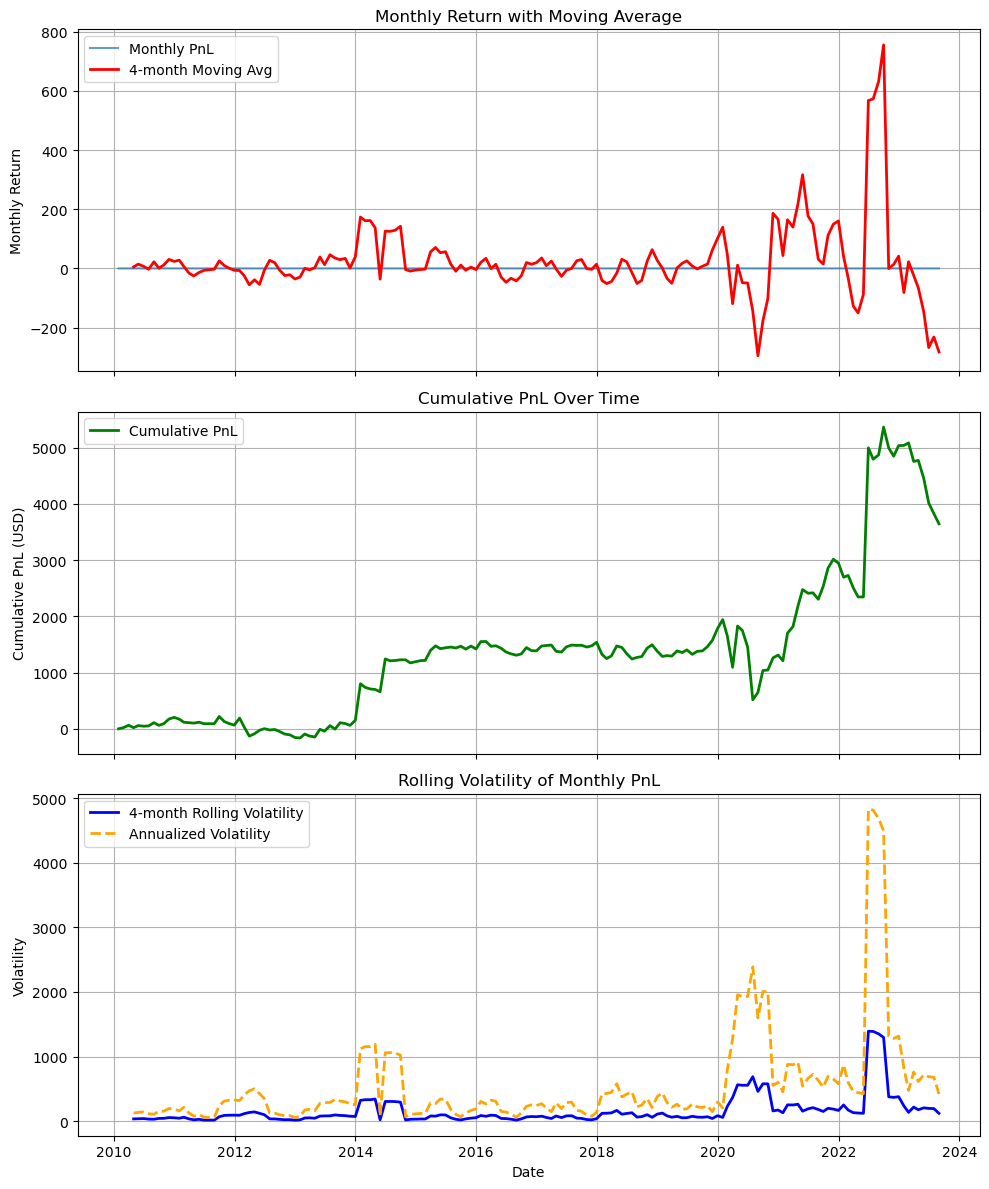

,count,mean,std,min,25%,50%,75%,max
monthly_return,164.00,0.00,0.00,-0.01,-0.00,0.00,0.00,0.03


In [119]:
plot_monthly_pnl(strat_returns)

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

def compute_tail_metrics(data: pd.Series, level: float) -> tuple:
    """Compute VaR and Expected Shortfall for a given quantile level."""
    var = data.quantile(level)
    es = data[data <= var].mean()  # average loss below the quantile
    return var, es

def plot_pnl_distribution(pnl_df: pd.DataFrame, column: str = 'pnl', bins: int = 30) -> pd.DataFrame:
    """
    Plots the PnL distribution with histogram and KDE, and calculates tail metrics.
    
    Parameters:
      pnl_df: DataFrame containing a PnL column (default name 'pnl').
      column: The column name in pnl_df to use for the PnL data.
      bins: Number of bins for the histogram (default is 30).
      
    Returns:
      summary_df: A styled DataFrame with summary metrics including quantiles, VaR, ES, skewness, and kurtosis.
    """
    # Extract and drop NaN values from the PnL data.
    data = pnl_df[column].dropna()
    
    mean_val = data.mean()
    median_val = data.median()
    mode_series = data.mode()
    # If you want to display the mode, you can uncomment the following line:
    # mode_val = mode_series.iloc[0] if not mode_series.empty else np.nan
    
    plt.figure(figsize=(10, 6))
    
    # Plot histogram and KDE of the PnL data.
    sns.histplot(data, bins=bins, stat="density", color="skyblue", edgecolor="black", alpha=0.6, label="PnL Histogram")
    sns.kdeplot(data, color='red', lw=2, label='KDE')
    
    # Plot vertical lines for mean and median.
    plt.axvline(mean_val, color='green', linestyle='--', lw=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='blue', linestyle='--', lw=2, label=f'Median: {median_val:.2f}')
    # To include the mode, uncomment the following:
    # plt.axvline(mode_val, color='purple', linestyle='--', lw=2, label=f'Mode: {mode_val:.2f}')
    
    plt.title("Distribution of PnL")
    plt.xlabel("PnL (USD)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute tail metrics and moments.
    q1 = data.quantile(0.01)
    q99 = data.quantile(0.99)
    var_1, es_1 = compute_tail_metrics(data, 0.01)
    var_5, es_5 = compute_tail_metrics(data, 0.05)
    skew_val = skew(data)
    kurt_val = kurtosis(data)
    
    summary = {
        '1% Quantile': q1,
        '99% Quantile': q99,
        '1% VaR': var_1,
        '1% ES': es_1,
        '5% VaR': var_5,
        '5% ES': es_5,
        'Skewness': skew_val,
        'Kurtosis': kurt_val
    }
    
    summary_df = pd.DataFrame(summary, index=["Value"]).style.format("{:.2f}")
    return summary_df


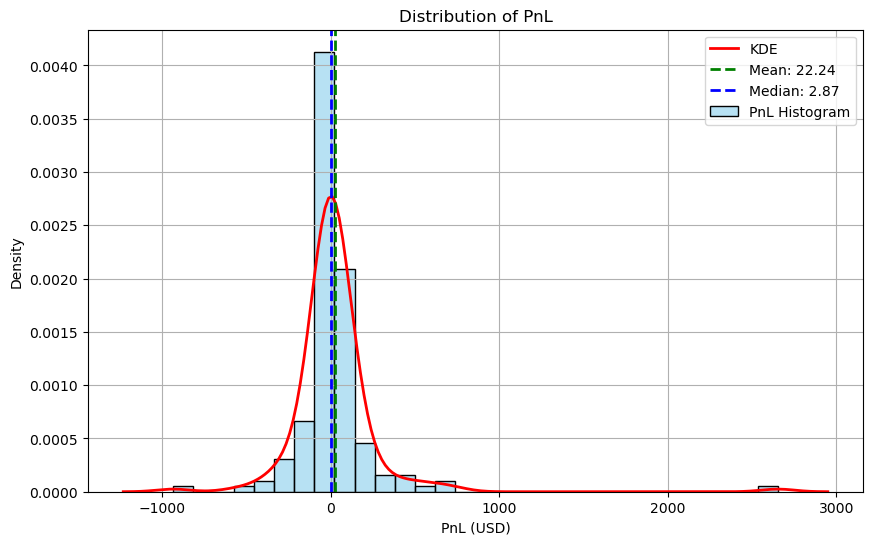

,1% Quantile,99% Quantile,1% VaR,1% ES,5% VaR,5% ES,Skewness,Kurtosis
Value,-480.86,682.21,-480.86,-745.45,-246.77,-421.53,5.34,51.32


In [121]:
plot_pnl_distribution(strat_returns)

In [122]:
import numpy as np
import pandas as pd

def calculate_performance_metrics(pnl_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates a range of performance metrics from the monthly return DataFrame.
    
    Expects pnl_df to have columns:
      - 'monthly_return' (monthly return as a decimal, e.g., 0.02 for +2%)
      - 'cum_return' (cumulative return as a decimal, e.g., 0.50 for +50%)
    """
    # Average and standard deviation of monthly returns
    avg_return = pnl_df['monthly_return'].mean()
    std_return = pnl_df['monthly_return'].std()
    # Annualize Sharpe ratio using √12 (assuming risk-free rate of 0)
    sharpe = (avg_return / std_return * np.sqrt(12)) if std_return != 0 else np.nan

    # Maximum drawdown from the cumulative return series
    running_max = pnl_df['cum_return'].cummax()
    max_dd = (pnl_df['cum_return'] - running_max).min()

    # Number of periods (months)
    num_periods = len(pnl_df)

    # Downside standard deviation and Sortino ratio (only for months with negative return)
    downside = pnl_df.loc[pnl_df['monthly_return'] < 0, 'monthly_return']
    downside_std = downside.std() if len(downside) > 0 else np.nan
    sortino = (avg_return / downside_std * np.sqrt(12)) if downside_std and not np.isnan(downside_std) else np.nan

    # Win ratio: percentage of months with positive return
    win_ratio = (pnl_df['monthly_return'] > 0).mean() * 100

    # Profit factor: sum of gains divided by absolute sum of losses
    sum_wins = pnl_df.loc[pnl_df['monthly_return'] > 0, 'monthly_return'].sum()
    sum_losses = pnl_df.loc[pnl_df['monthly_return'] < 0, 'monthly_return'].sum()
    profit_factor = sum_wins / abs(sum_losses) if sum_losses != 0 else np.nan

    # Calculate maximum consecutive wins and losses
    monthly_returns = pnl_df['monthly_return'].values
    max_consec_wins = 0
    max_consec_losses = 0
    current_wins = 0
    current_losses = 0
    for r in monthly_returns:
        if r > 0:
            current_wins += 1
            current_losses = 0
        else:
            current_losses += 1
            current_wins = 0
        max_consec_wins = max(max_consec_wins, current_wins)
        max_consec_losses = max(max_consec_losses, current_losses)

    metrics = {
        'Average Monthly Return': avg_return,
        'Std Monthly Return': std_return,
        'Annualized Sharpe Ratio': sharpe,
        'Annualized Sortino Ratio': sortino,
        'Maximum Drawdown': max_dd,
        'Number of Periods': num_periods,
        'Win Ratio (%)': win_ratio,
        'Profit Factor': profit_factor,
        'Max Consecutive Wins': max_consec_wins,
        'Max Consecutive Losses': max_consec_losses,
    }

    summary_df = pd.DataFrame(metrics, index=["Value"]).T.style.format("{:.4f}")
    return summary_df


In [123]:
calculate_performance_metrics(strat_returns)

,Value
Average Monthly Return,0.0004
Std Monthly Return,0.0041
Annualized Sharpe Ratio,0.3673
Annualized Sortino Ratio,0.9528
Maximum Drawdown,-0.0218
Number of Periods,164.0000
Win Ratio (%),51.8293
Profit Factor,1.4861
Max Consecutive Wins,6.0000
Max Consecutive Losses,5.0000
